Controversial Picks Calculator (by Bobby Mills and Arseny Khakhalin)

For now this script doesn't perform a full analysis. It needs to be run on the set for human player, then it should be manually made run for a bot, and then there's an R script named `controversial_picks_part2.R` that finalizes the comparison.

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import re

import itertools

import matplotlib.pyplot as plt
import mpld3

In [2]:
from draftsim_utils_ab import *

In [3]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)

Change the set abbrevation below to work with a different set

In [4]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'WAR'

In [5]:
thisSet = mtgJSON[setName]['cards']

thisSet = {getName(card) : card for card in thisSet} # a dict with names as indices for cards, for all cards in set

In [6]:
dataFileNames = {
    'XLN': '../../2018-02-23 Two days data XLN.csv',
    'DOM': '../../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../../2019-01-22 RNA merged.csv',
    'WAR': '../../2019-04-29 WAR prerelease leadup.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
3910313,WAR,"Liliana,_Dreadhorde_General,Liliana's_Triumph,...","Storrev,_Devkarin_Lich,Band_Together,Davriel,_...","God-Eternal_Bontu,Gleaming_Overseer,Vizier_of_...","Vivien,_Champion_of_the_Wilds,Nahiri,_Storm_of...","Awakening_of_Vitu-Ghazi,Challenger_Troll,Wards...","Sarkhan_the_Masterless,Spark_Harvest,Turret_Og...","Domri's_Ambush,Band_Together,Kiora,_Behemoth_B...","Chandra's_Triumph,Mobilized_District,Trusted_P..."
3910314,WAR,"Sarkhan_the_Masterless,Domri,_Anarch_of_Bolas,...","Dreadhorde_Invasion,Vizier_of_the_Scorpion,Dea...","Dovin,_Hand_of_Control,Law-Rune_Enforcer,Marty...","Roalesk,_Apex_Hybrid,Silent_Submersible,Samut,...","Kaya,_Bane_of_the_Dead,Spark_Harvest,Sorin's_T...","Ajani,_the_Greathearted,Jaya's_Greeting,Tibalt...","Vivien's_Arkbow,Cyclops_Electromancer,Spark_Do...","Domri's_Ambush,Jaya's_Greeting,Bolt_Bend,Turre..."
3910315,WAR,"Jaya,_Venerated_Firemage,Law-Rune_Enforcer,Pou...","Spark_Harvest,Casualties_of_War,Davriel,_Rogue...","Vizier_of_the_Scorpion,Angrath,_Captain_of_Cha...","Eternal_Skylord,Turret_Ogre,Sorin's_Thirst,Sky...","Enter_the_God-Eternals,Herald_of_the_Dreadhord...","God-Eternal_Oketra,The_Wanderer,Sorin,_Vengefu...","Jaya's_Greeting,Angrath,_Captain_of_Chaos,Emer...","Time_Wipe,Mowu,_Loyal_Companion,Ajani's_Pridem..."
3910316,WAR,"Teferi,_Time_Raveler,Tamiyo's_Epiphany,Guild_G...","Kaya,_Bane_of_the_Dead,Jaya's_Greeting,Law-Run...","Vraska,_Swarm's_Eminence,Bleeding_Edge,Eternal...","Eternal_Skylord,Vraska's_Finisher,Callous_Dism...","Samut,_Tyrant_Smasher,Arlinn,_Voice_of_the_Pac...","Enter_the_God-Eternals,Totally_Lost,Ugin's_Con...","Vivien's_Arkbow,Huatli,_the_Sun's_Heart,Courag...","Spark_Harvest,Jaya's_Greeting,Raging_Kronch,Ch..."
3910317,WAR,"Nissa,_Who_Shakes_the_World,Thundering_Ceratok...","Eternal_Skylord,Chandra's_Triumph,Mobilized_Di...","Nicol_Bolas,_Dragon-God,Kiora,_Behemoth_Beckon...","Ob_Nixilis's_Cruelty,Sorin's_Thirst,Soul_Divin...","God-Eternal_Kefnet,Augur_of_Bolas,Ral's_Outbur...","Domri,_Anarch_of_Bolas,Kasmina,_Enigmatic_Ment...","Bleeding_Edge,Gleaming_Overseer,Vraska's_Finis...","Ob_Nixilis's_Cruelty,Ob_Nixilis's_Cruelty,Tiba..."


In [7]:
#print(thisSet.keys())
dict((k.lower(), v) for k, v in thisSet.items()) # Lowercase the keys
cardlist = list(thisSet.keys())
#print(cardlist)

Main loop, but it's actually quite fast (~10 s).

In [19]:
cardpicks = {card : [] for card in cardlist} # Pick order
cardpickOn = {card : [] for card in cardlist} # Pick order on color

draftCount = 0
player = 'human' # normally should be: human, but can also be bot1 or another bot
for draft in draftData[player]:
    draft = fixName(draft)
    draft = draft.lower()
    draft = draft.split(',')
    draftCount += 1
    #colorCount = {i : 0 for i in range(0,6)}
    colorCount = [0,0,0,0,0,0,0]
    for i in range(14):
        try:
            cardpicks[draft[i]].append(i+1)
            bestColorSoFar = np.argmax(colorCount)
            if bestColorSoFar==0 or getCardColor(thisSet[draft[i]]) == bestColorSoFar:
                cardpickOn[draft[i]].append(i+1)
            colorCount[getCardColor(thisSet[draft[i]])] += 1            
        except KeyError as e:
            print(draft)
            print(count)
            raise
    #if any('karn_scion_of_urza' in x for x in draft):
    #    print(cardpicks['karn_scion_of_urza'][-1])
    #    #print(draft)
    
print("Analyzed ",draftCount," records.")

Analyzed  61878  records.


In [20]:
for card in cardpicks:
    if cardpicks[card] == []:
        cardpicks[card].append(15)
        
for card in cardpickOn:
    if cardpickOn[card] == []:
        cardpickOn[card].append(15)

Text(0,0.5,'Frequency')

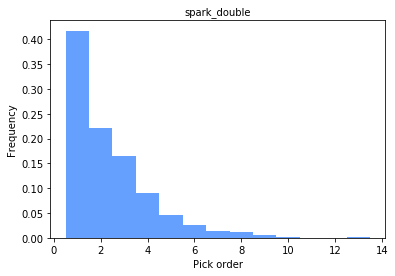

In [21]:
#cardpicks['karn_scion_of_urza']
#cardpicks['karn_scion_of_urza']
#cardpicks['chance_for_glory']

goodCardName = 'spark_double' 
# Controversial in GRN: ionize, chance_for_glory. Well known: leapfrog, silent_dart

# Histogram of cardpicks
fig, ax = plt.subplots()
n, bins, patches = plt.hist(cardpicks[goodCardName], 13, range=(0.5,13.5), density=True, facecolor=(0.2,0.5,1), alpha=0.75)
ax.set_title(goodCardName, size=10)
plt.xlabel('Pick order')
plt.ylabel('Frequency') 

In [22]:
cardpicksdf = pd.DataFrame({
        'avg' : [np.mean(cardpicks[card]) for card in cardpicks],
        'var' : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity' :[thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks]
    }, list(cardpicks.keys()))
#cardpicksdf.head()

In [41]:
cardpickOndf = pd.DataFrame({
        'avg' : [np.mean(cardpickOn[card]) for card in cardpickOn],
        'var' : [np.var(cardpickOn[card]) for card in cardpickOn],
        'count' : [len(cardpickOn[card]) for card in cardpickOn],
        'color' : [getCardColor(thisSet[card]) for card in cardpickOn],
        'rarity' :[thisSet[card]['rarity'] for card in cardpickOn],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpickOn]
    }, list(cardpickOn.keys()))

In [23]:
if player=='human':
    cardpicksdf.to_csv('../../data/controversial_cards_'+setName+'.csv', index_label="name")
    #cardpickOndf.to_csv('../../data/controversial_cards_data_onColor.csv', index_label="name")
else:
    cardpicksdf.to_csv('../../data/controversial_cards_'+setName+'_bot.csv', index_label="name")
    #cardpickOndf.to_csv('../../data/controversial_cards_data_onColor_bot.csv', index_label="name")

In [18]:
cardpicksdf.sort_values(by=['var'], ascending=False).head(10)
#cardpicksdf.iloc[0]['rarity'] == 'Common'

,avg,var,count,color,rarity,legendary
niv-mizzet_reborn,9.245584,19.790971,1755,1,mythic,1
role_reversal,8.825334,18.330625,2542,1,rare,0
tamiyo_collector_of_tales,7.550562,18.056111,3115,1,rare,1
teferi_time_raveler,6.843373,17.971306,4565,1,rare,1
tenth_district_legionnaire,6.990732,17.766365,3237,1,uncommon,0
rubblebelt_rioters,7.738573,16.628794,2341,1,uncommon,0
mayhem_devil,7.360639,16.025956,2942,1,uncommon,0
pledge_of_unity,8.480060,15.979287,5993,1,uncommon,0
angrath's_rampage,7.891935,15.813197,4414,1,uncommon,0
cruel_celebrant,7.520586,15.739665,3279,1,uncommon,0


In [23]:
def getHeights(picks):
    heights = [0 for x in range(16)]
    
    for num in picks:
        heights[num] +=1
        
    return heights

In [24]:
colorkey = ['0', 'M', 'W', 'U', 'B', 'G', 'R']
colorid = ['#9F9F9F', 'DC03FD', '#F3C750', '#0E68AB', '#150B00', '#00733E', '#D3202A']
mplcolors = ['gray', 'mediumvioletred', 'orange', 'dodgerblue', 'black', 'g', 'red']


In [25]:
mplrarity = ['crimson','orange','gray', 'black', 'w']
rarity= ['Mythic Rare', 'Rare', 'Uncommon', 'Common', 'Basic Land']

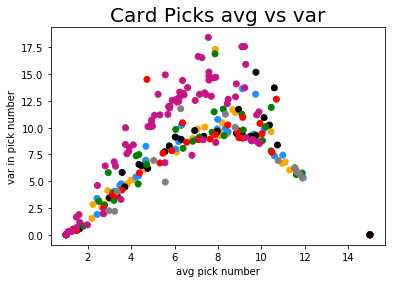

In [26]:
fig, ax = plt.subplots()

scatter = ax.scatter(cardpicksdf['avg'],
                     cardpicksdf['var'],
                     c = [mplcolors[x] for x in cardpicksdf['color']]
                    )

ax.set_title("Card Picks avg vs var", size=20)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 

labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#plt.savefig('avgvsvar.png')

#mpld3.display()

ValueError: 'mythic' is not in list

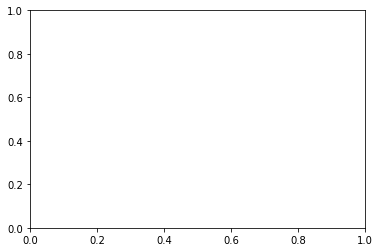

In [28]:
fig, ax = plt.subplots()

scatter = ax.scatter(cardpicksdf['avg'],
                     cardpicksdf['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']]
                    )

ax.set_title("Card Picks avg vs var by rarity", size=20)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 



labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#plt.savefig('avgvsvarRarityDom.png')

#mpld3.display()

ValueError: 'mythic' is not in list

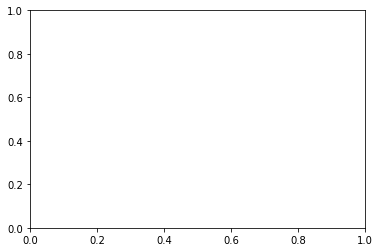

In [29]:
fig, ax = plt.subplots()

#The top scatter is for legendary cards. The bottom is non legendary.
#You can comment one out for more clarity

scatter = ax.scatter(cardpicksdf.loc[cardpicksdf['legendary'] == 1]['avg'],
                     cardpicksdf.loc[cardpicksdf['legendary'] == 1]['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']],
                     marker = 's'
                    )
scatter = ax.scatter(cardpicksdf.loc[cardpicksdf['legendary'] == 0]['avg'],
                     cardpicksdf.loc[cardpicksdf['legendary'] == 0]['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']],
                     marker = 'o'
                    )

ax.set_title("Card Picks avg vs var by rarity", size=10)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 



labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

plt.savefig('avgvsvarRarityDomNormal.png')

mpld3.display()